In [1]:
# # Run this and then restart the kernel at the start of each session to install
# # 'teotil3' in development mode
# !pip install -e /home/jovyan/projects/teotil3/

In [2]:
import copy
import os
import pprint as pp

import geopandas as gpd
import matplotlib.pyplot as plt
import nivapy3 as nivapy
import numpy as np
import pandas as pd
import seaborn as sn
import teotil3 as teo
from lmfit import Parameters, fit_report, minimize
from shapely.geometry import Point
from sklearn.metrics import r2_score
from tqdm.notebook import tqdm

plt.style.use("ggplot")

# Task 2.15: Testing, documentation and reporting

## Part D: Calibrate retention

The notebook for [Task 2.5a](https://nbviewer.org/github/NIVANorge/teotil3/blob/main/notebooks/development/T2-5a_est_vollenweider_params_from_data.ipynb) used literature values to build Vollenweider-style retention models for the parameters included in TEOTIL3. The notebook for [Task 2.15b](https://nbviewer.org/github/NIVANorge/teotil3/blob/main/notebooks/development/T2-15b_compare_measured_fluxes.ipynb) then compared simulated fluxes from the new model to those measured by monitoring programmes.

Without any adjustment or calibration, the model performs reasonably well for most parameters. The plots below give an indication of the **initial uncalibrated performance** (where the panel on the right shows the same data with log-axes; note that R2 values apply to the unlogged data).

 * For all parameters, the model output shows an obvious positive correlation with observations.

 * **For nitrogen**, DIN is simulated well, although the log-log plot shows a slight tendency to over-predict DIN fluxes in most catchments. Modelled TON fluxes are also consistently too high, suggesting that retention of TON is probably too low.
   
 * **For phosphorus**, TPP is over-predicted, while TDP is under-predicted. The bias is not always consistent, however, with the log-log plots suggesting that TDP, in particular, is over-predicted in small catchments and under-predicted in large ones. The lack of interannual variability captured in the TDP series implies that retention is probably too high for this parameter, while for TPP it is possible that retention is a little too low.

 * **TOC** is consistently under-predicted, suggesting that retention may be too high.

 * **SS** is substantially under-predicted and performance is in general much worse than for the other parameters.

![Uncalibrated performance](../../images/uncalibrated_performance.png)

This notebook explores calibrating the retention "hyperparameters" (i.e. the parameters of the Vollenweider models) in order to correct clear biases and achieve a better fit to the observed data. This must be done carefully, however, to avoid "overfitting" - a situation where a model is adjusted to fit a particular calibration dataset, but does then not generalise well to new data.

In order to avoid overfitting, parameter estimates in the final retention models have been adjusted conservatively i.e. the calibrated values are not used directly, but are instead used to guide adjustment within the range of uncertainty identified by the original statistical modelling (Task 2.5a). The final model will then be further evaluated in several case study catchments to ensure results are plausible when evaluated against independent data.

## 1. Calibration code


In [3]:
def validate_input(model_pars, voll_dict, params):
    """Check user input is valid."""
    for model_par in model_pars:
        if model_par not in voll_dict:
            raise KeyError(f"Model parameter '{model_par}' not in 'voll_dict'.")

    for par in params.keys():
        model_par, calib_par = par.split("_")
        if model_par not in voll_dict:
            raise KeyError(f"Model parameter '{model_par}' not in 'voll_dict'.")
        if calib_par not in voll_dict[model_par]:
            raise KeyError(
                f"Calibration parameter '{calib_par}' not in 'voll_dict[{model_par}]'."
            )


def read_observed(model_pars):
    """Read observed fluxes."""
    obs_csv = os.path.join(eval_fold, "rid_vannmiljo_obs_data_aggregated.csv")
    obs_df = pd.read_csv(obs_csv)
    obs_df[obs_df == 0] = np.nan
    obs_df.dropna(how="any", inplace=True)

    # Get just pars of interest
    cols = [f"{par.upper()}_tonnes" for par in model_pars]
    obs_df = obs_df[["station_id", "regine", "year"] + cols]

    # Convert to long
    obs_df = obs_df.melt(
        id_vars=["station_id", "regine", "year"], value_name="observed"
    )

    return obs_df


def remove_prefix(text, prefix):
    """Remove 'prefix' from 'text'."""
    if text.startswith(prefix):
        return text[len(prefix) :]
    return text


def is_kystfelt(code):
    """Return 1 if regine is a kystfelt (numeric code after decimal), otherwise zero."""
    try:
        int(code.split(".")[1])
        return True
    except ValueError:
        return False


def run_model(params, st_yr, end_yr, model_pars, voll_dict, dtm_res):
    """Run the model from 'st_yr' to 'end_yr' for the parameters in 'model_pars'. Retention
    parameters for the Vollenweider models are taken from 'params' and the form of the models
    is defined in 'voll_dict'.
    """
    # Get relevant observed data
    obs_df = read_observed(model_pars)
    obs_df = obs_df.query("@st_yr <= year <= @end_yr")

    # Run TEOTIL3
    years = range(st_yr, end_yr + 1)
    df_list = []
    for year in years:
        csv_path = os.path.join(
            csv_fold,
            f"teotil3_input_data_nve{nve_data_year}_{year}.csv",
        )
        in_df = pd.read_csv(csv_path)
        in_df.columns = in_df.columns.str.replace("-", "")

        # Reduce number of columns for speed
        cols = [
            col for col in in_df.columns if any(f"_{par}" in col for par in model_pars)
        ]
        in_df = in_df[
            ["regine", "regine_down", "a_cat_land_km2", "runoff_mm/yr", "q_cat_m3/s"]
            + cols
        ]

        # Update retention estimates based on new parameters
        for par in model_pars:
            del in_df[f"trans_{par}"]

        calib_dict = copy.deepcopy(voll_dict)
        for par_name, par in params.items():
            model_par, calib_par = par_name.split("_")
            calib_dict[model_par][calib_par] = par.value

        ret_df = teo.preprocessing.assign_regine_retention(
            reg_df, regine_col="regine", dtm_res=dtm_res, voll_dict=calib_dict
        )
        trans_cols = [col for col in ret_df.columns if col.startswith("trans_")]
        ret_df = ret_df[["regine"] + trans_cols]

        # Set transmission = 1 for kystfelt
        mask = ret_df["regine"].apply(is_kystfelt)
        ret_df.loc[mask, trans_cols] = 1

        in_df = pd.merge(in_df, ret_df, how="left", on="regine")
        for col in trans_cols:
            in_df[col].fillna(1, inplace=True)

        # Run TEOTIL
        g = teo.model.run_model(
            in_df,
            id_col="regine",
            next_down_col="regine_down",
            totals_from_subfracs=True,
        )
        res_df = teo.model.model_to_dataframe(
            g, id_col="regine", next_down_col="regine_down"
        )
        res_df["year"] = year
        df_list.append(res_df)
    mod_df = pd.concat(df_list, axis="rows")

    # Reshape
    cols = [col for col in mod_df.columns if col.startswith("accum_")]
    mod_df = mod_df[["regine", "year"] + cols].copy()
    cols = [remove_prefix(col, "accum_") for col in cols]
    mod_df.columns = ["regine", "year"] + cols
    for par in model_pars:
        cols = [col for col in mod_df.columns if f"_{par}_" in col]
        mod_df[f"{par.upper()}_tonnes"] = mod_df[cols].sum(axis="columns") / 1000
    cols = [f"{par.upper()}_tonnes" for par in model_pars]
    mod_df = mod_df[["regine", "year"] + cols]

    # Convert to long
    mod_df = mod_df.melt(id_vars=["regine", "year"], value_name="modelled")

    # Join
    res_df = pd.merge(obs_df, mod_df, how="left", on=["regine", "year", "variable"])

    return res_df


def residual(params, st_yr, end_yr, model_pars, voll_dict, dtm_res):
    """Function to minimise."""
    res_df = run_model(params, st_yr, end_yr, model_pars, voll_dict, dtm_res)

    residual = res_df["observed"] - res_df["modelled"]

    return residual

## 2. Input data

In [4]:
# Basic options
nve_data_year = 2023
st_yr, end_yr = 2013, 2022
dtm_res = 10

# File paths
csv_fold = r"/home/jovyan/shared/common/teotil3/annual_input_data"
eval_fold = r"/home/jovyan/shared/common/teotil3/evaluation"
gpkg_fold = r"/home/jovyan/shared/common/teotil3/core_data"

In [5]:
# Read tidied regine data
teo_gpkg = os.path.join(gpkg_fold, "tidied", "teotil3_data.gpkg")
reg_df = gpd.read_file(teo_gpkg, layer="regines", driver="GPKG")[["regine"]]
reg_df.head()

,regine
0,001.10
1,001.1A1
2,001.1A20
3,001.1A2A
4,001.1A2B


## 3. Calibrate

The code in this section can be used to calibrate any of the parameters of interest. Uncomment the block for the desired parameter and run the notebook. Results can be found in the subfolder `calibration`.

### 3.1. SS

In [6]:
# # Define parameters of interest and default Vollenweider models (based on original literature data)
# model_pars = ["ss"]
# voll_dict = {
#     "ss": {"ind_var_col": "res_time_yr", "model": "sigma_constant", "sigma": 90}
# }

# # Set Vollenweider parameters for calibration
# params = Parameters()
# params.add("ss_sigma", value=90, min=1, max=100, vary=True)

# validate_input(model_pars, voll_dict, params)

### 3.2. N

In [7]:
# # Define parameters of interest and default Vollenweider models (based on original literature data)
# model_pars = ["din", "ton"]
# voll_dict = {
#     "din": {"ind_var_col": "hyd_load_mpyr", "model": "sigma_from_depth", "s": 6.0},
#     "ton": {"ind_var_col": "hyd_load_mpyr", "model": "sigma_from_depth", "s": 1.4},
# }

# # Set Vollenweider parameters for calibration
# params = Parameters()
# params.add("din_s", value=6.0, min=3, max=12, vary=True)
# params.add("ton_s", value=1.4, min=0.5, max=5, vary=True)

# validate_input(model_pars, voll_dict, params)

### 3.3. P

In [8]:
# # Define parameters of interest and default Vollenweider models (based on original literature data)
# model_pars = ["tdp", "tpp"]
# voll_dict = {
#     "tdp": {
#         "ind_var_col": "res_time_yr",
#         "model": "sigma_from_tau",
#         "k": 0.5,
#         "p": 0.5,
#     },
#     "tpp": {
#         "ind_var_col": "res_time_yr",
#         "model": "sigma_from_tau",
#         "k": 2,
#         "p": 0.5,
#     },
# }

# # Set Vollenweider parameters for calibration
# params = Parameters()
# params.add("tdp_k", value=0.5, min=0.1, max=4, vary=True)
# params.add("tdp_p", value=0.5, min=0.1, max=4, vary=True)
# params.add("tpp_k", value=2, min=0.1, max=4, vary=True)
# params.add("tpp_p", value=0.5, min=0.1, max=4, vary=True)

# validate_input(model_pars, voll_dict, params)

### 3.4. TOC

In [9]:
# Define parameters of interest and default Vollenweider models (based on original literature data)
model_pars = ["toc"]
voll_dict = {
    "toc": {
        "ind_var_col": "res_time_yr",
        "model": "sigma_from_tau",
        "k": 0.6,
        "p": 0.4,
    }
}

# Set Vollenweider parameters for calibration
params = Parameters()
params.add("toc_k", value=0.6, min=0.1, max=2, vary=True)
params.add("toc_p", value=0.4, min=0.1, max=2, vary=True)

validate_input(model_pars, voll_dict, params)

In [10]:
%%time
res = minimize(
    residual,
    params,
    args=(st_yr, end_yr, model_pars, voll_dict, dtm_res),
    nan_policy="omit",
)
print(fit_report(res))

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 38
    # data points      = 200
    # variables        = 2
    chi-square         = 4.3080e+09
    reduced chi-square = 21757661.2
    Akaike info crit   = 3381.08523
    Bayesian info crit = 3387.68187
[[Variables]]
    toc_k:  0.16942484 +/- 0.02580281 (15.23%) (init = 0.6)
    toc_p:  0.16199265 +/- 0.04290679 (26.49%) (init = 0.4)
[[Correlations]] (unreported correlations are < 0.100)
    C(toc_k, toc_p) = +0.9753
CPU times: user 30min 11s, sys: 19 s, total: 30min 30s
Wall time: 31min 2s


## 4. Plot

In [11]:
# Run model with optimised parameters
res_df = run_model(res.params, st_yr, end_yr, model_pars, voll_dict, dtm_res)

<Axes: xlabel='observed', ylabel='modelled'>

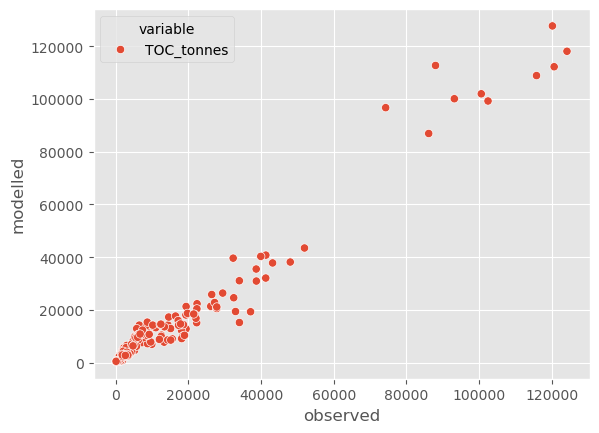

In [12]:
sn.scatterplot(res_df, x="observed", y="modelled", hue="variable")

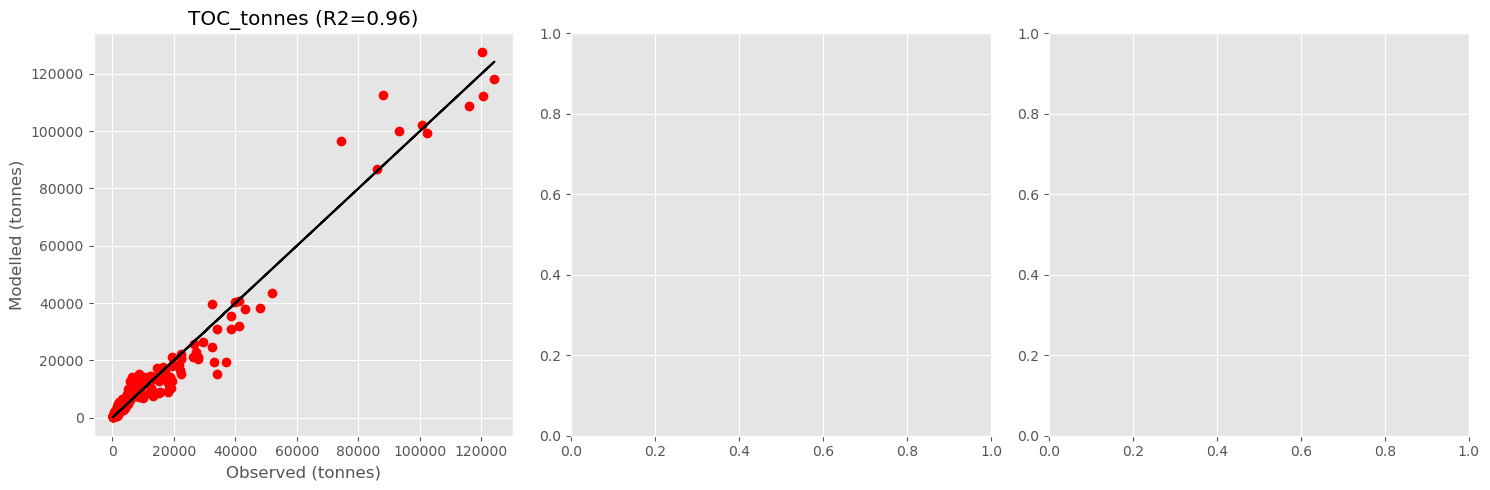

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
par_list = res_df["variable"].unique().tolist()
for idx, par in enumerate(par_list):
    par_df = res_df.query("variable == @par").copy()
    r2 = r2_score(par_df["observed"], par_df["modelled"])
    axes[idx].plot(par_df["observed"], par_df["modelled"], "ro")
    axes[idx].plot(par_df["observed"], par_df["observed"], "k-", label="1:1 line")
    axes[idx].set_title(f"{par} (R2={r2:.2f})")
    axes[idx].set_xlabel("Observed (tonnes)")
    axes[idx].set_ylabel("Modelled (tonnes)")
    # axes[idx].set_xscale('log')
    # axes[idx].set_yscale('log')
plt.tight_layout()